# Notebook 08: Advanced Analysis & Future Directions

**Objective**: Explore advanced single-cell analysis techniques beyond basic clustering.

## What you will learn:
- Cell cycle scoring and analysis
- Gene set enrichment analysis (GSEA)
- Trajectory inference concepts
- Data integration strategies
- Next steps for specialized analyses

## Beyond Basic Analysis

We've completed the core single-cell pipeline. Now let's explore **advanced techniques** that can provide deeper biological insights.

**Advanced Topics**:
1. **Cell Cycle Analysis**: Are cells proliferating?
2. **Gene Set Enrichment**: What pathways are active?
3. **Trajectory Inference**: Cell differentiation paths (conceptual)
4. **Integration**: Combining multiple datasets
5. **Specialized Analyses**: RNA velocity, cell-cell communication

## Note on This Notebook

This notebook is **exploratory**. Some analyses require:
- Additional packages (scVelo, CellRank, etc.)
- Larger datasets
- Specific experimental designs

We'll demonstrate **what's possible** and provide **starting points**.

## Workflow:
1. Load annotated data
2. Cell cycle scoring
3. Gene set enrichment analysis
4. Trajectory inference (conceptual)
5. Integration strategies
6. Resources for advanced analyses

In [1]:
# Import libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Paths
data_dir = '../data/'
results_dir = '../results/'

print("Libraries imported successfully!")
print(f"Scanpy version: {sc.__version__}")

Libraries imported successfully!
Scanpy version: 1.11.4


## 1. Load Annotated Data

Load the final annotated dataset.

In [5]:
# Load annotated data
adata = sc.read_h5ad(f'{data_dir}pbmc3k_annotated.h5ad')

print("=" * 60)
print("LOADED DATA")
print("=" * 60)
print(adata)
print(f"\nDimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"Cell types: {adata.obs['cell_type_merged'].nunique()}")

LOADED DATA
AnnData object with n_obs × n_vars = 2134 × 13671
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_1.0', 'leiden_0.4', 'leiden_0.8', 'leiden_1.5', 'leiden_2.0', 'leiden', 'cell_type', 'cell_type_merged'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'cell_type_merged_colors', 'dendrogram_cell_type_merged', 'dendrogram_leiden', 'hvg', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.8', 'leiden_0.8_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_2.0', 'leiden_2.0_colors', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Dimensions: 2134 cells × 13671 genes
Cell types: 6


## 2. Cell Cycle Analysis

### Why Analyze Cell Cycle?

**Cell cycle** affects gene expression:
- Proliferating cells express cycle-related genes (MKI67, TOP2A, etc.)
- Can confound clustering if not accounted for
- Important for understanding cell states

### Cell Cycle Phases:
- **G1**: Growth phase 1
- **S**: DNA synthesis
- **G2/M**: Growth phase 2 / Mitosis

Scanpy can score cells based on known cell cycle genes.

In [6]:
# Cell cycle scoring
# Scanpy has built-in cell cycle genes
cell_cycle_genes = [x.strip() for x in """
TPX2
UBE2C
TOP2A
BIRC5
CCNB2
CCNB1
AURKB
BUB1
KIF11
CDKN3
CENPF
TACC3
FAM64A
SMC4
CCNB1
CKAP2L
CKAP2
AURKB
BUB1
KIF11
KIF2C
NUF2
NDC80
MKI67
HMGB2
CDK1
NUSAP1
UBE2C
BIRC5
TPX2
TOP2A
""".split('\n') if x.strip()]

# Filter to available genes
s_genes = [g for g in cell_cycle_genes[:15] if g in adata.var_names]
g2m_genes = [g for g in cell_cycle_genes[15:] if g in adata.var_names]

print(f"S phase genes available: {len(s_genes)}")
print(f"G2/M phase genes available: {len(g2m_genes)}")

if len(s_genes) > 0 and len(g2m_genes) > 0:
    # Score cell cycle
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    
    print("\n✅ Cell cycle scoring complete!")
    print(f"Phases identified: {adata.obs['phase'].value_counts().to_dict()}")
else:
    print("⚠️ Not enough cell cycle genes available")

S phase genes available: 12
G2/M phase genes available: 15
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    72 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    107 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)

✅ Cell cycle scoring complete!
Phases identified: {'S': 1102, 'G1': 1009, 'G2M': 23}


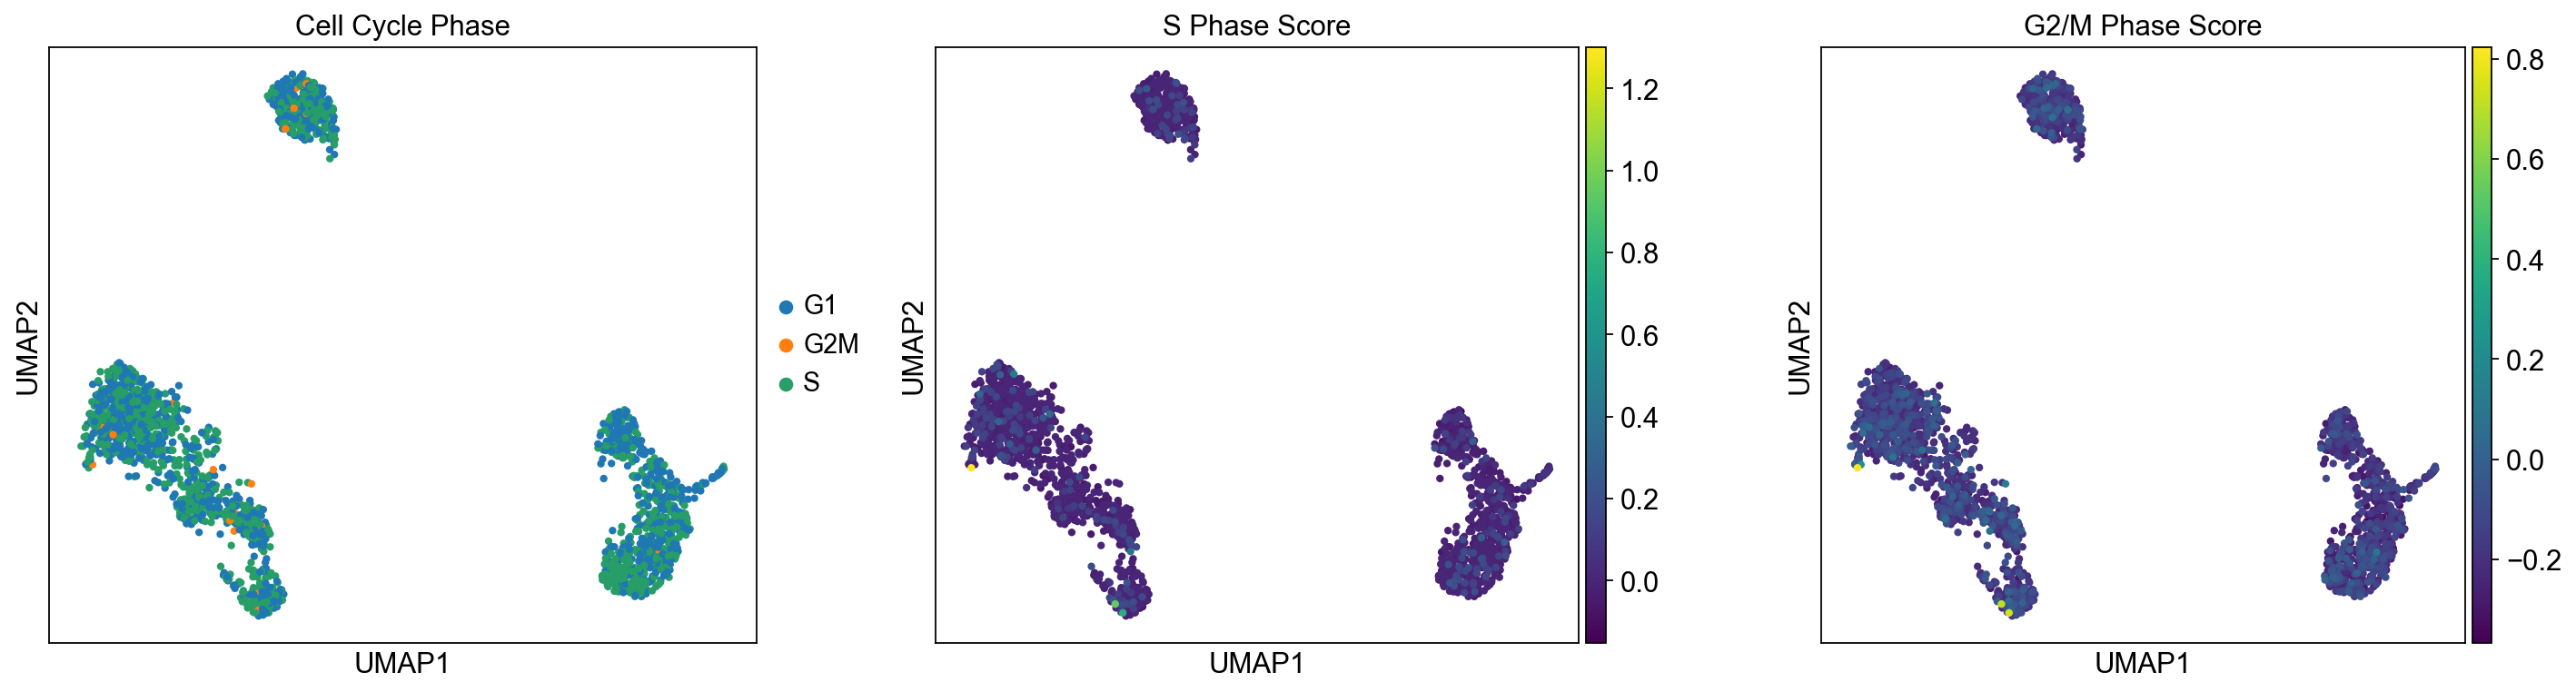

📊 Cell cycle visualization created


In [7]:
# Visualize cell cycle on UMAP
if 'phase' in adata.obs.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Cell cycle phase
    sc.pl.umap(adata, color='phase', ax=axes[0], show=False, title='Cell Cycle Phase')
    
    # S score
    sc.pl.umap(adata, color='S_score', ax=axes[1], show=False, title='S Phase Score', cmap='viridis')
    
    # G2M score
    sc.pl.umap(adata, color='G2M_score', ax=axes[2], show=False, title='G2/M Phase Score', cmap='viridis')
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}08_cell_cycle_umap.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Cell cycle visualization created")

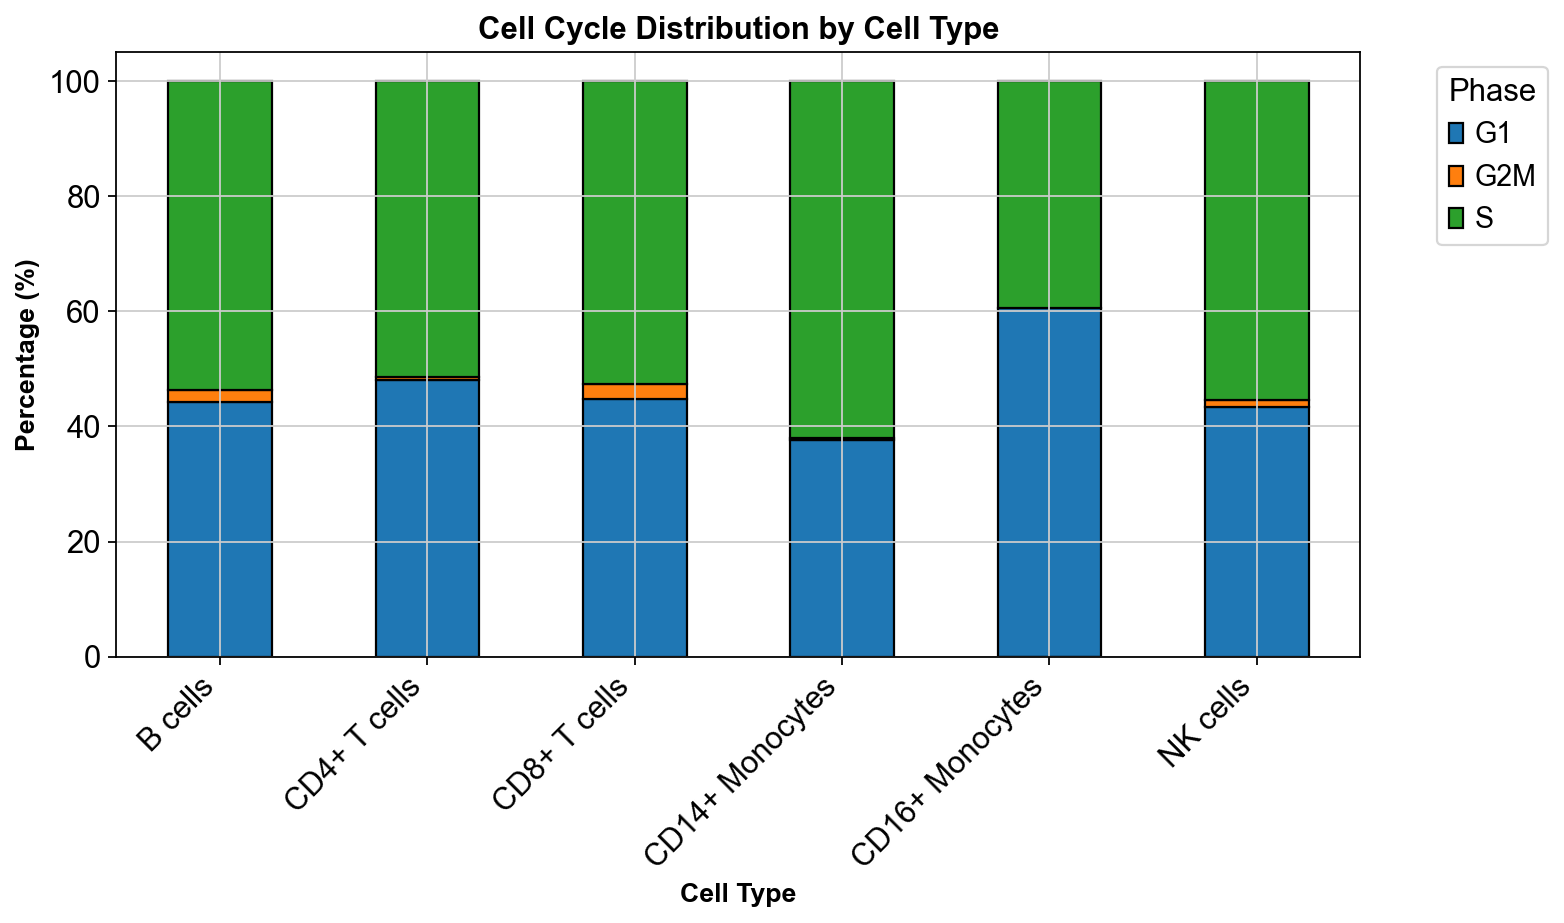

📊 Cell cycle by cell type

Percentage in each phase:
phase               G1  G2M     S
cell_type_merged                 
B cells           44.3  2.0  53.7
CD4+ T cells      48.0  0.5  51.5
CD8+ T cells      44.8  2.7  52.5
CD14+ Monocytes   37.7  0.3  62.0
CD16+ Monocytes   60.5  0.0  39.5
NK cells          43.4  1.3  55.3


In [8]:
# Cell cycle by cell type
if 'phase' in adata.obs.columns:
    phase_counts = pd.crosstab(adata.obs['cell_type_merged'], adata.obs['phase'], normalize='index') * 100
    
    phase_counts.plot(kind='bar', stacked=True, figsize=(10, 6), 
                      color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black')
    plt.xlabel('Cell Type', fontsize=12, fontweight='bold')
    plt.ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    plt.title('Cell Cycle Distribution by Cell Type', fontsize=14, fontweight='bold')
    plt.legend(title='Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{results_dir}08_cell_cycle_by_celltype.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("📊 Cell cycle by cell type")
    print("\nPercentage in each phase:")
    print(phase_counts.round(1))

## 3. Gene Set Enrichment Analysis (Conceptual)

### What is GSEA?

**Gene Set Enrichment Analysis** tests if predefined gene sets (pathways, GO terms) are enriched in your data.

**Example questions**:
- Are immune response genes upregulated in monocytes?
- Are cell cycle genes enriched in proliferating cells?
- What pathways distinguish CD4+ from CD8+ T cells?

### Tools for GSEA:
- **GSEApy**: Python implementation
- **gseapy.enrichr()**: Enrichment analysis
- **MSigDB**: Curated gene sets
- **GO/KEGG**: Pathway databases

### Note:
Full GSEA requires additional packages (`gseapy`) and is beyond this tutorial's scope.
We'll show the **concept** and **how to get started**.

In [10]:
# Example: Get top genes for a cell type
print("=" * 60)
print("EXAMPLE: TOP GENES FOR ENRICHMENT ANALYSIS")
print("=" * 60)

# Get top 100 genes for CD4+ T cells
if 'rank_genes_celltype' in adata.uns:
    result = adata.uns['rank_genes_celltype']
    
    if 'CD4+ T cells' in result['names'].dtype.names:
        cd4_genes = result['names']['CD4+ T cells'][:100].tolist()
        
        print(f"\nTop 100 genes for CD4+ T cells:")
        print(f"First 20: {', '.join(cd4_genes[:20])}")
        print(f"\n💡 These genes can be used for enrichment analysis with:")
        print("   - Enrichr (https://maayanlab.cloud/Enrichr/)")
        print("   - DAVID (https://david.ncifcrf.gov/)")
        print("   - g:Profiler (https://biit.cs.ut.ee/gprofiler/)")
        print("   - GSEApy (Python package)")

EXAMPLE: TOP GENES FOR ENRICHMENT ANALYSIS


## 4. Trajectory Inference (Conceptual)

### What is Trajectory Inference?

**Trajectory inference** reconstructs cell differentiation paths:
- Stem cells → Differentiated cells
- Naive T cells → Effector T cells
- Monocytes → Macrophages

### Popular Tools:
- **PAGA**: Partition-based graph abstraction (built into Scanpy)
- **Monocle3**: R package for trajectories
- **scVelo**: RNA velocity (requires spliced/unspliced counts)
- **CellRank**: Combines velocity with Markov chains

### Note on PBMC Data:
PBMCs are **mature circulating cells**, so trajectories are limited. Better for:
- Hematopoiesis (bone marrow)
- Development (embryonic data)
- Differentiation experiments

We'll demonstrate **PAGA** as a starting point.

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


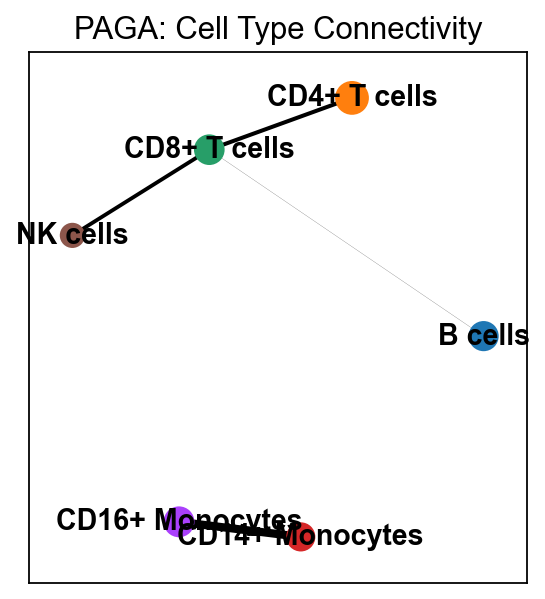

PAGA graph created
Thicker edges = stronger connectivity between cell types
For PBMCs, limited trajectories expected (mature cells)


In [12]:
# PAGA (Partition-based Graph Abstraction)
# Compute PAGA
sc.tl.paga(adata, groups='cell_type_merged')

# Plot PAGA
sc.pl.paga(adata, show=False, title='PAGA: Cell Type Connectivity')
plt.savefig(f'{results_dir}08_paga_graph.png', dpi=150, bbox_inches='tight')
plt.show()

print("PAGA graph created")
print("Thicker edges = stronger connectivity between cell types")
print("For PBMCs, limited trajectories expected (mature cells)")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)


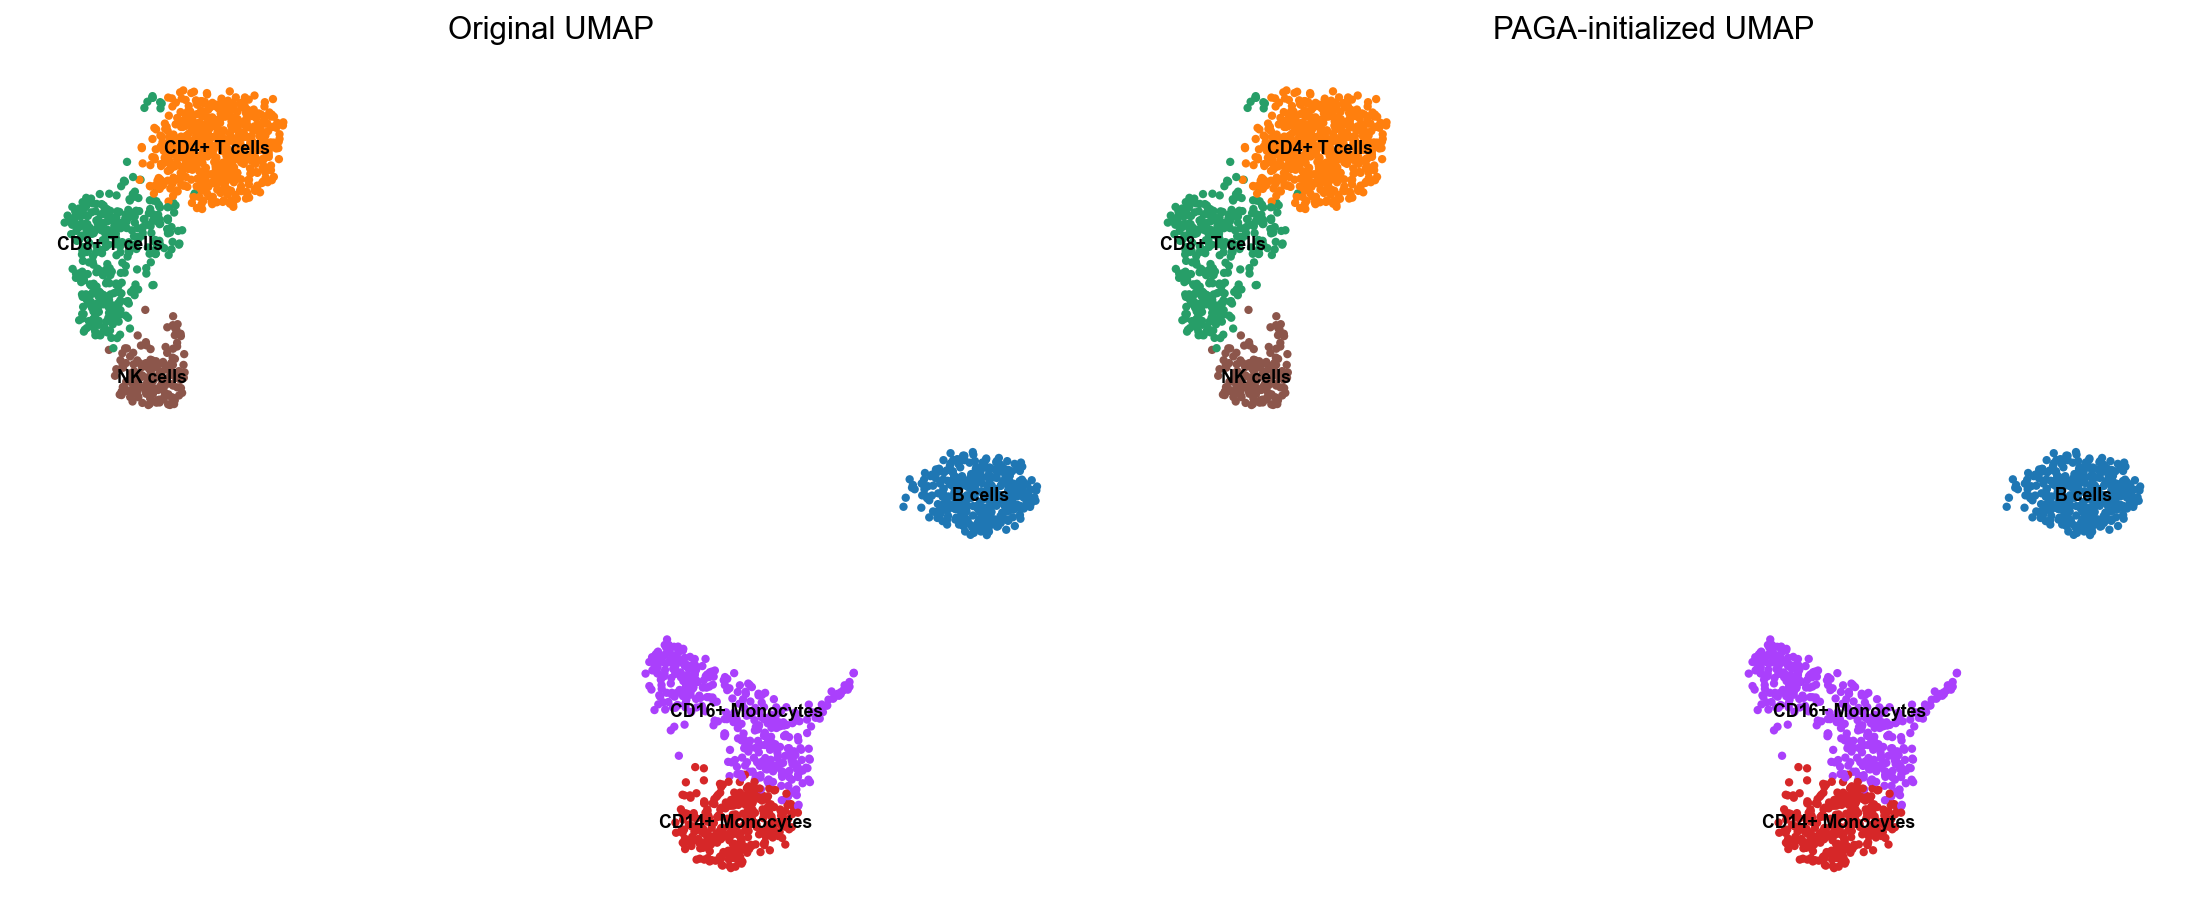

📊 PAGA-initialized UMAP
💡 PAGA can help preserve biological relationships in UMAP


In [13]:
# PAGA-initialized UMAP
sc.tl.umap(adata, init_pos='paga')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original UMAP
sc.pl.umap(adata, color='cell_type_merged', ax=axes[0], show=False, 
           title='Original UMAP', frameon=False, legend_loc='on data', legend_fontsize=8)

# PAGA-initialized UMAP
sc.pl.umap(adata, color='cell_type_merged', ax=axes[1], show=False,
           title='PAGA-initialized UMAP', frameon=False, legend_loc='on data', legend_fontsize=8)

plt.tight_layout()
plt.savefig(f'{results_dir}08_paga_umap.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 PAGA-initialized UMAP")
print("💡 PAGA can help preserve biological relationships in UMAP")

## 5. Data Integration (Conceptual)

### Why Integrate Data?

When analyzing **multiple samples** or **batches**:
- Batch effects can confound biology
- Need to integrate datasets while preserving biological variation

### Integration Methods:
- **Harmony**: Fast, scalable
- **Scanorama**: Panorama-based
- **BBKNN**: Batch-balanced KNN
- **Seurat Integration**: R-based (CCA, RPCA)
- **scVI**: Deep learning-based

### When to Use:
- Multiple donors
- Different sequencing runs
- Cross-platform integration
- Disease vs healthy comparisons

### Example Workflow:
```python
# Conceptual example (requires multiple samples)
# import scanpy.external as sce
# sce.pp.harmony_integrate(adata, key='batch')
# sc.pp.neighbors(adata, use_rep='X_pca_harmony')
# sc.tl.umap(adata)
```

#### Note: Our PBMC3k is a single sample, so integration not needed.

## 6. Advanced Analysis Resources

### 🔬 Specialized Analyses

#### **RNA Velocity** (scVelo)
- Predicts future cell states
- Requires spliced/unspliced counts
- Shows differentiation direction
- **Tutorial**: [https://scvelo.readthedocs.io/](https://scvelo.readthedocs.io/)

#### **Cell-Cell Communication** (CellPhoneDB, LIANA)
- Ligand-receptor interactions
- Signaling between cell types
- **Tutorial**: [https://www.cellphonedb.org/](https://www.cellphonedb.org/)

#### **Gene Regulatory Networks** (SCENIC, pySCENIC)
- Transcription factor analysis
- Regulon activity
- **Tutorial**: [https://pyscenic.readthedocs.io/](https://pyscenic.readthedocs.io/)

#### **Spatial Transcriptomics** (Squidpy)
- Tissue architecture
- Spatial patterns
- **Tutorial**: [https://squidpy.readthedocs.io/](https://squidpy.readthedocs.io/)

#### **Perturbation Analysis** (Perturb-seq)
- CRISPR screens
- Gene function
- **Tutorial**: Scanpy perturbation tutorials

---

### 📚 Learning Resources

**Official Documentation**:
- Scanpy: [https://scanpy.readthedocs.io/](https://scanpy.readthedocs.io/)
- Scanpy Tutorials: [https://scanpy-tutorials.readthedocs.io/](https://scanpy-tutorials.readthedocs.io/)
- Single-cell Best Practices: [https://www.sc-best-practices.org/](https://www.sc-best-practices.org/)

**Courses**:
- Analysis of single cell RNA-seq data (Sanger Institute)
- Single Cell Genomics Day (Broad Institute)
- Current Best Practices in Single-Cell RNA-Seq

**Papers**:
- Luecken & Theis (2019): Current best practices in single-cell RNA-seq
- Hie et al. (2019): Efficient integration of heterogeneous single-cell transcriptomes

---

### 🛠️ Recommended Packages

```bash
# Core
pip install scanpy

# Visualization
pip install scvelo  # RNA velocity
pip install cellrank  # Trajectory inference

# Integration
pip install harmonypy  # Batch correction
pip install scanorama  # Integration

# Enrichment
pip install gseapy  # Gene set enrichment

# Communication
pip install liana  # Ligand-receptor analysis

# Regulatory
pip install pyscenic  # Gene regulatory networks

## 7. Export Final Dataset

Save the complete analyzed dataset with all annotations and scores.

In [17]:
# Save final dataset
adata.write(f'{data_dir}pbmc3k_final.h5ad')

print("Final dataset saved!")
print(f"File: {data_dir}pbmc3k_final.h5ad")
print(f"\nFinal state:")
print(f"  - Cells: {adata.n_obs}")
print(f"  - Genes: {adata.n_vars}")
print(f"  - Cell types: {adata.obs['cell_type_merged'].nunique()}")
if 'phase' in adata.obs.columns:
    print(f"  - Cell cycle scored: Yes")
print(f"  - PAGA computed: Yes")

Final dataset saved!
File: ../data/pbmc3k_final.h5ad

Final state:
  - Cells: 2134
  - Genes: 13671
  - Cell types: 6
  - Cell cycle scored: Yes
  - PAGA computed: Yes


## Summary

### What we accomplished:

1. **Cell Cycle Analysis**:
   - Scored cells for S and G2/M phases
   - Visualized cell cycle distribution
   - Analyzed proliferation by cell type

2. **Gene Set Enrichment** (Conceptual):
   - Explained GSEA principles
   - Provided resources and tools
   - Showed how to extract gene lists

3. **Trajectory Inference** (Conceptual):
   - Introduced PAGA
   - Demonstrated PAGA-initialized UMAP
   - Discussed limitations for PBMC data

4. **Data Integration** (Conceptual):
   - Explained batch correction
   - Listed integration methods
   - Provided example workflow

5. **Advanced Resources**:
   - RNA velocity, cell-cell communication
   - Gene regulatory networks
   - Learning resources and tutorials

---

### Key Takeaways

#### **What We Learned**:
1. ✅ **Cell cycle** affects gene expression and can be quantified
2. ✅ **GSEA** reveals pathway-level insights
3. ✅ **Trajectory inference** reconstructs differentiation (when applicable)
4. ✅ **Integration** handles batch effects in multi-sample studies
5. ✅ **Many specialized tools** exist for specific questions

#### **When to Use Advanced Analyses**:
- **Cell cycle**: When proliferation is important (cancer, development)
- **GSEA**: To understand functional differences
- **Trajectories**: For differentiation, development data
- **Integration**: Multi-sample, multi-batch experiments
- **Velocity**: To predict cell fate (requires special data)

---

### Your Single-Cell Journey

**You've completed a full single-cell RNA-seq analysis!**

**From raw data to biological insights**:
1. ✅ Quality control and filtering
2. ✅ Normalization and preprocessing
3. ✅ Dimensionality reduction
4. ✅ Clustering
5. ✅ Marker gene identification
6. ✅ Cell type annotation
7. ✅ Biological interpretation
8. ✅ Advanced analysis concepts

---

### Next Steps for Your Research

**Apply these skills to**:
- Your own datasets
- Different tissues/organs
- Disease vs healthy comparisons
- Time-series experiments
- Perturbation studies

**Keep learning**:
- Explore specialized analyses (velocity, communication)
- Read single-cell papers
- Join the community (Scanpy Discourse, Twitter)
- Contribute to open-source tools

---

**Congratulations! You're now equipped to analyze single-cell RNA-seq data!** 

**Happy analyzing!** 